In [169]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
from tqdm import tqdm
import pandas_datareader as pdr
import datetime
from numpy.linalg import inv
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [170]:
start = datetime.datetime(2004, 1, 1)
end = datetime.datetime.now()
df = pdr.get_data_fred('DFF', start, end)
df = df[df.index.dayofweek < 5]
df /= 100


# Vasicek model parameters

In [171]:
def vasicek_log_likelihood(params, rates, dt):
    a, b, sigma = params
    n = len(rates)
    mu = b + (rates[:-1] - b) * np.exp(-a * dt)
    sigma_v = np.sqrt((sigma**2 / (2 * a)) * (1 - np.exp(-2 * a * dt)))
    log_likelihood = -0.5 * np.sum(np.log(2 * np.pi * sigma_v**2) + ((rates[1:] - mu)**2 / sigma_v**2))
    return -log_likelihood

In [172]:
rates = df.dropna().values
dt = 1 / 252  # Assuming daily data; adjust accordingly if using different frequency

# Initial parameter guesses (a, b, sigma)
initial_params = [0.1, 0.1, 0.1]

# Estimate the parameters using MLE
result = minimize(vasicek_log_likelihood, initial_params, bounds=[(1e-6, None), (None, None), (1e-6, None)], args=(rates, dt))
a_mle, b_mle, sigma_mle = result.x

# Display estimated parameters
print(f"Estimated a: {a_mle}")
print(f"Estimated b: {b_mle}")
print(f"Estimated sigma: {sigma_mle}")

Estimated a: 0.07168795710745386
Estimated b: 0.04470367202358553
Estimated sigma: 0.01064269150756088


In [173]:
# Numerical approximation of the Hessian matrix and final estimation results display
estimates = np.array([a_mle, b_mle, sigma_mle])
step = 1e-5 * estimates
n_params = len(estimates)

# Initialize the Hessian matrix
H = np.zeros((n_params, n_params))

# Compute the Hessian matrix using finite differences
for i in range(n_params):
    for j in range(n_params):
        delta_i = np.zeros(n_params)
        delta_j = np.zeros(n_params)
        delta_i[i] = step[i]
        delta_j[j] = step[j]
        
        f_ij = vasicek_log_likelihood(estimates + delta_i + delta_j, rates, dt)
        f_i_neg_j = vasicek_log_likelihood(estimates + delta_i - delta_j, rates, dt)
        f_neg_i_j = vasicek_log_likelihood(estimates - delta_i + delta_j, rates, dt)
        f_neg_i_neg_j = vasicek_log_likelihood(estimates - delta_i - delta_j, rates, dt)
        
        H[i, j] = (f_ij - f_i_neg_j - f_neg_i_j + f_neg_i_neg_j) / (4 * step[i] * step[j])

# Invert the Hessian matrix to get the variance-covariance matrix
vcv = inv(H)

# Extract standard errors
std_err = np.sqrt(np.diag(vcv))

# Compute t-statistics
t_stats = estimates / std_err

# Display results
print('Parameter   Estimate       Std. Err.      T-stat')
param = ['a', 'b', 'sigma']
for i in range(n_params):
    print('{0:<11} {1:>0.6f}        {2:0.6f}    {3: 0.5f}'.format(param[i],
           estimates[i], std_err[i], t_stats[i]))

Parameter   Estimate       Std. Err.      T-stat
a           0.071688        0.121638     0.58936
b           0.044704        0.058515     0.76397
sigma       0.010643        0.000103     103.11862


# Simulation of interest rate paths

In [153]:
a = a_mle
b = b_mle
sigma = sigma_mle
r0 = df.iloc[-1]

T_values = np.arange(1, 13) / 12

# Simulation parameters
num_paths = 10000
num_steps = 100
dt = 1/252

def simulate_vasicek_path(a, b, sigma, r0, num_steps, dt):
    rates = np.zeros(num_steps)
    rates[0] = r0
    for t in range(1, num_steps):
        dr = a * (b - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates[t] = rates[t-1] + dr
    return rates

def zc_bond_price(r, t, T, a, b, sigma):
    B = (1 - np.exp(-a * (T - t))) / a
    A = np.exp((b - (sigma**2) / (2 * a**2)) * (B - (T - t)) - (sigma**2) * B**2 / (4 * a))
    return A * np.exp(-B * r)

data = []
for _ in tqdm(range(num_paths)):
    rates = simulate_vasicek_path(a, b, sigma, r0, num_steps, dt)
    for t in range(num_steps):
        for T in T_values:
            price = zc_bond_price(rates[t], t*dt, T, a, b, sigma)
            data.append([rates[t], t*dt, T, price])

data = np.array(data)

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_42465/223898460.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rates[0] = r0
100%|██████████| 10000/10000 [00:53<00:00, 188.10it/s]


# Deep surrogate

In [154]:
# Split the data
X = data[:, :3]  # Features: rate, time, maturity
y = data[:, 3]   # Target: bond price

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [155]:
# Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(3,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val), callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])


Epoch 1/2


/Users/ahmadroukain/PycharmProjects/pythonProject4/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


262500/262500 ━━━━━━━━━━━━━━━━━━━━ 155s 587us/step - loss: 3.8963e-04 - val_loss: 2.5738e-09
Epoch 2/2
262500/262500 ━━━━━━━━━━━━━━━━━━━━ 151s 574us/step - loss: 8.1715e-08 - val_loss: 2.0892e-08


In [156]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')


56250/56250 ━━━━━━━━━━━━━━━━━━━━ 18s 320us/step - loss: 2.0900e-08
Test Loss: 2.090818362887603e-08


That is the test, it's very good, our model worked well

In [157]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 24s 429us/step
Mean Absolute Error (MAE): 0.0001312809589413363
Mean Squared Error (MSE): 2.090810846159205e-08
R-squared (R²): 0.9999204215137494


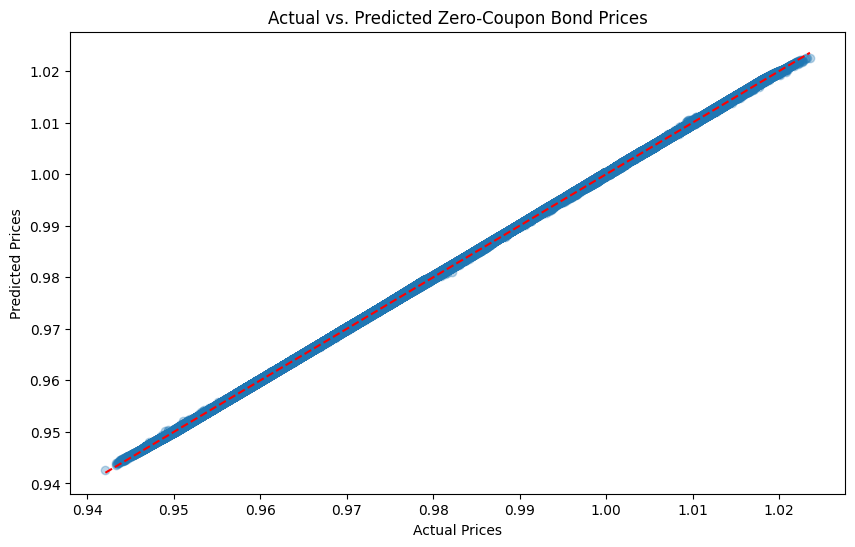

In [184]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Zero-Coupon Bond Prices')
plt.savefig('deep_surr_prediction.png')
plt.show()

# Trying the model

In [174]:
new_input = scaler.transform([[r0[0], 0, 3/12]]) 
predicted_price = model.predict(new_input)
print(f'Predicted ZC Bond Price: {predicted_price[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted ZC Bond Price: 0.9869484305381775


/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_42465/615073716.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_input = scaler.transform([[r0[0], 0, 3/12]])


In [175]:
new_input = scaler.transform([[r0[0], 0, 6/12]]) 
predicted_price = model.predict(new_input)
print(f'Predicted ZC Bond Price: {predicted_price[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted ZC Bond Price: 0.9739894866943359


/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_42465/3061417294.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_input = scaler.transform([[r0[0], 0, 6/12]])


In [176]:
new_input = scaler.transform([[r0[0], 0, 1]]) 
predicted_price = model.predict(new_input)
print(f'Predicted ZC Bond Price: {predicted_price[0][0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted ZC Bond Price: 0.9486499428749084


/var/folders/zq/cl9wyfm13sq150n30b6r3_6m0000gn/T/ipykernel_42465/645128804.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_input = scaler.transform([[r0[0], 0, 1]])


In [182]:
'https://www.worldgovernmentbonds.com/country/united-states/#:~:text=The%20United%20States%2010Y%20Government,Term%20vs%20Short%2DTerm%20Maturities.&text=Central%20Bank%20Rate%20is%205.50,last%20modification%20in%20July%202023).'

US3M_y = 5.411/100
US6M_y = 5.389/100
US1Y_y = 5.211/100
US3M = 1/(1+US3M_y)**(3/12)
US6M = 1/(1+US6M_y)**(6/12)
US1Y = 1/(1+US1Y_y)
US3M_p = 0.9869484305381775
US6M_p = 0.9739894866943359
US1Y_p = 0.9486499428749084

table_comparison = {
    "Actual price": [US3M, US6M, US1Y],
    "Predicted": [US3M_p, US6M_p, US1Y_p]
}

df = pd.DataFrame(data, index=["US3M", "US6M", "US1Y"])
df.to_latex('comparaison_prix.tex')


In [183]:
data

{'Actual price': [0.9869121977194025, 0.9740973417158957, 0.9504709583598672],
 'Predicted': [0.9869484305381775, 0.9739894866943359, 0.9486499428749084]}